<a href="https://colab.research.google.com/github/Yuvraj-Dhepe/uni_ml/blob/main/dida_task/Test_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading G-Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Importing and Installing the required Libraries

In [ ]:
!pip install albumentations
!pip install ipympl
!apt remove git -y
!apt-get install git -y && git clone https://github.com/tensorflow/examples.git

In [64]:
import os
import cv2
import keras
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
# Ignore the warnings of Matplotlib
warnings.filterwarnings("ignore", category=UserWarning)

from skimage.transform import resize
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import euclidean
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import vgg16, MobileNetV2
from examples.tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization,GlobalMaxPooling2D,\
 GlobalAveragePooling2D, Conv2DTranspose, ZeroPadding2D, concatenate, Input, Activation, Dropout

#import ipympl
# Enables Use of Ipympl to zoom in and out of the plots
# from google.colab import output
# output.enable_custom_widget_manager()
# from google.colab import output
# output.disable_custom_widget_manager()

In [4]:
%cd /content/gdrive/MyDrive/images/Dida_task

/content/gdrive/MyDrive/images/Dida_task


## Utility Functions & Variables

In [5]:
model_histories = {} # {model_name: training_history}
models = {} # {model_name:[model,tprs,fprs]} Used for simultaneous predictions and plotting roc curves.

### Preprocessing Functions

#### Changing Image Numbers for better tracking Function

In [6]:
# # Set the path to your train directories
# train_image_path = '/content/gdrive/MyDrive/images/dida_task/train/images'
# train_label_path = '/content/gdrive/MyDrive/images/dida_task/train/labels'

# # Rename the image files
# image_files = sorted(os.listdir(train_image_path))
# for i, file in enumerate(image_files):
#     src = os.path.join(train_image_path, file)
#     dst = os.path.join(train_image_path, f"{i+1}.png")
#     os.rename(src, dst)

# # Rename the label files
# label_files = sorted(os.listdir(train_label_path))
# for i, file in enumerate(label_files):
#     src = os.path.join(train_label_path, file)
#     dst = os.path.join(train_label_path, f"{i+1}.png")
#     os.rename(src, dst)

#### Image Loading and Preprocessing Functions

In [7]:
def train_test_img_loader(path:str, size:int)-> np.array:
  '''
  Load images from folders
  @param: path: directory path
  @param: size: new size for images
  '''
  # Getting Names of images
  image_files = sorted(os.listdir(path)) 
  # Blank array to store images
  images = []
  # Iterating through every image location, reading it and storing it in an array
  for file in image_files:
    image_path = os.path.join(path, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = resize(image, (size,size))
    images.append(resized_image)
  return np.array(images)

def label_img_loader(path:str, size:int)-> np.array:
  '''
  Load labels from folders
  @param: path: directory path
  @param: size: new size for images
  '''
  # Getting Names of images
  image_files = sorted(os.listdir(path)) 
  # Blank array to store images
  images = []
  # Iterating through every image location, reading it and storing it in an array
  for file in image_files:
    image_path = os.path.join(path, file)
    image = cv2.imread(image_path)
    gray_label = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    resized_label = resize(gray_label, (size,size))
    extended_image = tf.expand_dims(resized_label, axis = -1) # Grayscale channel
    binary_image = np.where(extended_image>0.5,1,0) # Binary Masking for the pixels, going with general condition that any pixel value greater than 0.5 is considered as part of roof else not roof.
    images.append(binary_image)
  return np.array(images)

#### Image Augmentation Function

In [8]:
def augment_images(images: np.array, labels:np.array, num_aug:int=6) -> tuple():
  '''
  Generate augmented images, per given image, this function generates num_aug images
  @param: images: Images to be augmented 
  @param: labels: Corresponding labels of images
  '''

  # Define the transforms to apply on both the images and the labels
  transforms = A.Compose([
      A.Resize(224, 224,interpolation = cv2.INTER_NEAREST), #Interpolation of image to preserve pixel values
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.Rotate(limit=45, p=0.5),
  ])

  # Get the list of images and labels
  images_list = images
  labels_list = labels
    
  # Define empty numpy arrays to store the augmented images and labels, uint 8 is used for efficient processing of images
  aug_image_list = np.empty((0,224,224,3),dtype = np.uint8)
  aug_label_list = np.empty((0,224,224,1),dtype = np.uint8)

  # Apply the transforms to each image and label pair and store them in corressponding arrays
  for i in range(len(images_list)):
    # Load the image and label and put it in our augmented list
    image = images_list[i]
    label = labels_list[i]
    aug_image_list = np.append(aug_image_list,[image],axis = 0)
    aug_label_list = np.append(aug_label_list,[label],axis = 0)

    for j in range(num_aug):
      # Apply the transforms to both the image and the label
      transformed = transforms(image=image, mask=label)
      image_transformed = transformed['image']
      label_transformed = transformed['mask']
      
      aug_image_list = np.append(aug_image_list,[image_transformed],axis = 0)
      aug_label_list = np.append(aug_label_list,[label_transformed],axis = 0)
  
  return aug_image_list, aug_label_list

#### Return Images to model.fit Function

In [9]:
def img(ip_type:str = 'augmented') -> tuple:
  '''
  Returns the images to the fit function
  @param: ip_type: Image Set to be Returned either normal images or augmented images
  '''
  if ip_type == 'normal':
    return processed_train_images,processed_train_labels,processed_val_images, processed_val_labels
  elif ip_type== 'augmented':
    return train_aug_images, train_aug_labels, val_aug_images, val_aug_labels

### Metrics Functions

#### Cross Validation Scores Generating Function

In [10]:
def cv(model:Model ,folds:int,dataset:str) -> None:
  '''
  Prints CV scores per fold and generate a viz, depicting the cv scores
  @param: model: A trained neural network
  @param: folds: Number of folds to divide the dataset
  @param: dataset: Type of dataset on which cross validation has to be performed
  '''
  # Load your data
  imgs = img(dataset)

  X = imgs[0]
  y = imgs[1]

  # Define the K-Fold cross-validation iterator
  kfold = KFold(n_splits=folds, shuffle=False, random_state=None)
  scores =  []
  fold_indices = []
  
  # Defining the splits indexes  
  for train_index, val_index in kfold.split(X):
      fold_indices.append((train_index, val_index))

  # Perform cross-validation
  for fold, (train_indices, val_indices) in enumerate(fold_indices):
      model = model
      print(f"Fold {fold+1}:")

      # Split the data into training and validation sets
      X_train, y_train = X[train_indices], y[train_indices]
      X_val, y_val = X[val_indices], y[val_indices]

      # Fit the model on the training set
      model.fit(X_train, y_train, epochs=15, batch_size=5, validation_data=(X_val, y_val), verbose=0)
      
      # Evaluate the model on the validation set
      score = model.evaluate(X_val, y_val, verbose=0)
      scores.append(score)
      print(f"Validation accuracy: {score[1]*100}%")
      print(f"Validation Loss: {score[0]*100}%")

  # Plot validation accuracy
  # Generate x-axis tick labels as integers
  scores = np.array(scores)
  xticks = np.arange(scores.shape[0])
  #print(fold_indices)
  # Plot the scores with integer xticks
  plt.plot(xticks, scores[:, 1], label='Val Accuracy')
  plt.plot(xticks, scores[:, 0], label='Val Loss')
  plt.xticks(xticks)
  plt.title('Validation Scores for Cross Validation')
  plt.legend()
  plt.show()

#### ROC Curve, Threshold, F1-Score, Recall, Precision Generating Functions

In [66]:
def model_score(model: Model,val_images: np.array,val_labels: np.array,tprs: list, fprs:list) -> None:
  '''
  Prints the Precision, Recall and F1-Score for a given model
  @params: model: A trained neural network
  @params: val_images: The validation images to generate preds
  @params: val_labels: The validation labels to compare with preds 
  @params: tprs: True Positive rate, generated from ROC 
  @params: fprs: False Positive rate, generate from ROC
  '''
  # Get best threshold
  best_threshold = thr_calc(tprs,fprs)

  # Make predictions on validation set
  predicted_images = model.predict(val_images)

  # Convert image to binary values depending on threshold
  binary_preds = (predicted_images>threshold).astype('uint8')
  binary_preds = np.reshape(binary_preds,(-1,224,224,1)) 

  # Calculate true positives, true negatives, false positives, and false negatives
  cm = confusion_matrix(val_labels.flatten(),binary_preds.flatten())
  tn,fp,fn,tp = cm.ravel()

  # Calculate precision, recall, and F1 score
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1_score = 2*(precision*recall)/(precision+recall)
  
  # Print the results
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1_score}")

def roc_curve(model: Model,val_images: np.array,val_labels: np.array) -> tuple:
  '''
  Build an ROC curve for various thresholds based on validation set and return corresponding tprs and fprs
  @param: model: A trained neural network
  @params: val_images: The validation images to generate preds
  @params: val_labels: The validation labels to compare with preds 
  '''
  # Make predictions on validation set
  predicted_images = model.predict(val_images)

  # Threshold the predicted images using different threshold values
  thresholds = np.arange(0, 1.05, 0.05) # check all thresholds from 0-1 in 0.05 interval
  tprs = []
  fprs = []

  for threshold in thresholds:
      # apply threshold and convert to binary images
      
      binary_images = (predicted_images > threshold).astype('uint8')
      binary_images = np.reshape(binary_images, (-1, 224, 224, 1))
      
      # calculate confusion matrix
      cm = confusion_matrix(val_labels.flatten(), binary_images.flatten())
      tn, fp, fn, tp = cm.ravel()
      
      # calculate TPR and FPR
      tpr = tp / (tp + fn)
      fpr = fp / (fp + tn)
      
      tprs.append(tpr)
      fprs.append(fpr)

  # plot the ROC curve
  plt.plot(fprs, tprs)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

  return tprs,fprs


def thr_calc(tprs:list, fprs:list) -> float:
  '''
  Calculate the best threshold value on base of TPRS and FPRS from ROC curve
  @param: tprs: True Positive Rate
  @param: fprs: False Positive Rate
  '''
  # Threshold the predicted images using different threshold values
  thresholds = np.arange(0, 1.05, 0.05) # check all thresholds from 0-1 in 0.05 interval

  # calculate distance to top left corner for each point on the ROC curve
  distances = [euclidean([0, 1], [fprs[i], tprs[i]]) for i in range(len(fprs))]

  # find index of point with smallest distance
  best_index = np.argmin(distances)

  # get corresponding threshold value which will be use to highlight the image
  best_threshold = thresholds[best_index]
  return best_threshold

#### Prediction Function

In [12]:
def test_predictions(model: Model,tprs:list,fprs:list) -> None:
  '''
  Generate predictions on the test set
  @param: model: A trained neural network
  @params: tprs: True Positive rate, generated from ROC 
  @params: fprs: False Positive rate, generate from ROC 
  '''
  # Get Best Threshold
  best_threshold = thr_calc(tprs,fprs)
  threshold = best_threshold 
  
  # Generate predictions with the model
  predicted_images = model.predict(processed_test_images) # predict on test images
  
  # apply threshold and convert to binary images
  binary_images = (predicted_images > threshold).astype('uint8')
  binary_images = np.reshape(binary_images, (-1, 224, 224, 1))
  
  # highlight rooftops in binary images
  print(f"Predictions for best threshold value: {best_threshold}")
  fig, axs = plt.subplots(1,5,figsize = (18,18),sharey = True)
  for i in range(binary_images.shape[0]):
    test_image = test_images[i]
    binary_image = binary_images[i].squeeze()
    
    # Create an image with only the rooftop pixels highlighted
    rooftop_image = np.zeros_like(test_image)
    rooftop_image[:,:,0] = binary_image*255 # set red channel to binary image
    
    # Blend the original image and the rooftop image to highlight rooftops
    final_image = cv2.addWeighted(test_image, 0.8, rooftop_image, 0.2, 0)  # 80% contribution of test image and 20% contribution of predicted image
    axs[i].imshow(final_image)
  plt.show()
  fig.tight_layout()   

### Metric Visualization Functions

#### All Models Joint Plot Function

In [13]:
def join_plots(model_histories:dict) -> None:
  '''
  Function to plot accuracy and loss from model histories, collected after every model training
  @param: model_histories: Dict(key:model_name -> val: model_history)
  '''
  model_histories = model_histories
  
  # Null Dictionaries to store the history
  train_loss = {}
  train_acc = {}
  val_loss = {}
  val_acc = {}

  # Storing Loss and Accuracy Metrics in appropriate dictionaries model wise
  for model, history in model_histories.items():
    train_loss[model] = history.history['loss'] 
    val_loss[model] = history.history['val_loss']
    train_acc[model] = history.history['accuracy']
    val_acc[model] = history.history['val_accuracy']

  # Degining the figure, and a join dictionary consisting of individual category metrics.
  fig,axs = plt.subplots(2,2,figsize = (18,12))
  categories = {'Val Accuracy':val_acc, 'Val Loss': val_loss,'Train Accuracy':train_acc,'Train Loss':train_loss,}

  # Axes Logic for Plotting
  # 1 -> 0,0
  # 2 -> 0,1
  # 3 -> 1,0
  # 4 -> 1,1

  l,m = 0,0
  
  # Going through every category metrics of val acc, val loss, train acc and train loss
  for category in categories:
    # In each category we iterate through a model and it's corresponding metric values.
    for model, val in categories[category].items():
      sns.lineplot(x = range(1,len(val)+1), y = val, label = model, ax = axs[l][m])
    axs[l][m].set_xticks([i for i in range(1,16)])
    axs[l][m].set_title(category)
    axs[l][m].set_xlabel('Epochs')
    axs[l][m].set_ylabel(category.split()[-1]) #Sets the label to Loss or Accuracy depending on category
    m+=1
    if m>1:
      l = 1
      m = 0

  plt.show()
  fig.tight_layout()

#### Single Model Metrics Plot Function

In [14]:
def acc_loss_plot(history:list):
  '''
  Function that plots accuracy and loss metrics from an Models History
  @param: history : Any model History
  '''
  # Get the loss from history object
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  
  # create figure and axis objects
  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

  # plot the training and validation loss
  sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=ax[0], label='train')
  sns.lineplot(x=range(len(val_loss)), y=val_loss, ax=ax[0], label='val')
  ax[0].set_title('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')

  # plot the training and validation accuracy
  sns.lineplot(x=range(len(train_acc)), y=train_acc, ax=ax[1], label='train')
  sns.lineplot(x=range(len(val_acc)), y=val_acc, ax=ax[1], label='val')
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')

  # show the plot
  plt.tight_layout()
  plt.show()

### Model Info and All Remaining Use Case Functions

In [15]:
def model_info(model: Model):
  '''
  Returns the whole architecture information for a model
  @param: model: A neural network architecture
  '''
  plot_model(model, to_file=f'{model.name}.png', show_shapes=True, rankdir='TB')
  layers = [(layer, layer.name, layer.trainable,layer.output.shape) for layer in model.layers]
  df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])
  return df

## Loading, Augmenting n Visualizing images

### Loading Images

In [16]:
# Directories of images
train_image_path = './train/images/'
train_label_path = './train/labels/'
val_image_path = './val/images/'
val_label_path = './val/labels/'
test_image_path = './test/images/'

# Loading the images from dirs
train_images = train_test_img_loader(train_image_path,224) # We are choosing this size so that Maxpooling works well
val_images = train_test_img_loader(val_image_path,224)
train_labels = label_img_loader(train_label_path,224)
val_labels = label_img_loader(val_label_path,224)
test_images = train_test_img_loader(test_image_path,224)

# Normalizing the images and making label images having enough channels for NN.
processed_train_images = train_images.astype('float32')
processed_val_images = val_images.astype('float32')
processed_test_images = test_images.astype('float32')
processed_train_labels = train_labels
processed_val_labels = val_labels

# Augmenting the images
train_aug_images, train_aug_labels = augment_images(processed_train_images,processed_train_labels)
val_aug_images, val_aug_labels = augment_images(processed_val_images,processed_val_labels)

In [17]:
# Checking the shape of images
#train_labels.shape,processed_train_images.shape,processed_val_images.shape,processed_val_labels.shape
train_aug_images.shape, train_aug_labels.shape, val_aug_images.shape, val_aug_labels.shape

((140, 224, 224, 3), (140, 224, 224, 1), (35, 224, 224, 3), (35, 224, 224, 1))

### Viewing the images

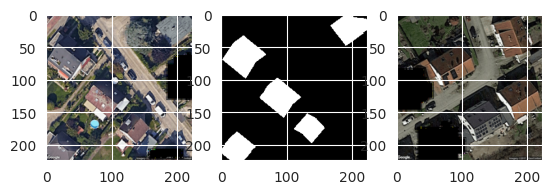

In [18]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(train_aug_images[110])
axs[1].imshow(train_aug_labels[110].squeeze(), cmap='gray')
axs[2].imshow(processed_test_images[0])
plt.show()

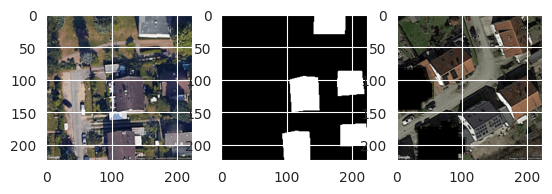

In [19]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(processed_train_images[0])
axs[1].imshow(processed_train_labels[0].squeeze(), cmap='gray')
axs[2].imshow(processed_test_images[0])
plt.show()

## Training Models with Various Architectures

### Base CNN Model: Trained From Scratch

In [61]:
# Define the CNN model
def CNN(input_size:np.array=(224, 224, 3), n_filters:int=16, n_classes:int=1,dropout_prob:float = 0.5):
    '''
    Returns a CNN architecture
    @param: input_size: input size of image
    @param: n_filters: Number of filters to be used in architecture layers
    @param: n_classes: Total Classes to be predicted
    @param: dropout_prob: Dropout probabilities
    '''
    input_shape = input_size
    model = Sequential(name='CNN')
    
    # Dropouts are used to avoid overfitting 
    
    # Downsampling an image by conv layers to extract features maps from images
    model = (Conv2D(n_filters*2, (5, 5), activation='relu', input_shape=input_shape, padding='valid'))(model)
    model = (MaxPooling2D(pool_size=(2, 2)))(model)
    model = (Dropout(dropout_prob))(model)
    model = (Conv2D(n_filters*4, (3, 3), activation='relu', padding='same'))(model)
    model = (MaxPooling2D(pool_size=(2, 2)))(model)
    model = (Dropout(dropout_prob))(model)
    model = (Conv2D(n_filters*8, (3, 3), activation='relu', padding='same'))(model)
    model = (MaxPooling2D(pool_size=(2, 2)))(model)
    model = (Dropout(dropout_prob))(model)
    model = (Conv2D(n_filters*16, (3, 3), activation='relu', padding='same'))(model)

    # Upsampling process to recover the spatial details and enhancing the resolution of the feature maps to produce more accurate outputs.
    model = (Conv2DTranspose(n_filters*8, (4, 4), strides=(2, 2), activation='relu', padding='same'))(model)
    model = (Dropout(dropout_prob))(model)
    model = (Conv2DTranspose(n_filters*4, (4, 4), strides=(2, 2), activation='relu', padding='same'))(model)
    model = (Dropout(dropout_prob))(model)
    model = (Conv2DTranspose(n_filters*2, (4, 4), strides=(2, 2), activation='relu', padding='same'))(model)
    model = (Dropout(dropout_prob))(model)
    model = (Conv2D(n_filters*4, (3, 3), activation='relu', padding='same'))(model)
    model = (Dropout(dropout_prob))(model)
    
    # This layer produces the final image output, representing the predicted probabilities for each pixel.
    # The sigmoid activation function is used to ensure the output values are between 0 and 1, representing the class probabilities.
    model = (Conv2D(n_classes, (3, 3), activation='sigmoid', padding='same'))(model)
    
    # Adding padding to get image as of same size of label
    model = (ZeroPadding2D(padding=((4, 4), (4, 4))))(model)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#### Loading and training the CNN model without augmented images

In [62]:
# Define the model
cnn = CNN()

# Get the model info
## model_info(cnn)

# Getting images
imgs = img('normal')

# Train the model
h_cnn = cnn.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))

# Storing the history 
model_histories['cnn'] = h_cnn
# Plotting the accuracy and loss for train and validation data
# We see all plots together at the end
# acc_loss_plot(h_cnn) 

Epoch 1/15
4/4 [==============================] - 4s 168ms/step - loss: 0.8207 - accuracy: 0.7594 - val_loss: 0.5972 - val_accuracy: 0.8497
Epoch 2/15
4/4 [==============================] - 0s 70ms/step - loss: 0.5818 - accuracy: 0.8407 - val_loss: 0.7125 - val_accuracy: 0.8497
Epoch 3/15
4/4 [==============================] - 0s 71ms/step - loss: 0.6615 - accuracy: 0.8502 - val_loss: 0.7076 - val_accuracy: 0.8497
Epoch 4/15
4/4 [==============================] - 0s 70ms/step - loss: 0.6616 - accuracy: 0.8561 - val_loss: 0.7001 - val_accuracy: 0.8497
Epoch 5/15
4/4 [==============================] - 0s 72ms/step - loss: 0.6543 - accuracy: 0.8564 - val_loss: 0.6916 - val_accuracy: 0.8497
Epoch 6/15
4/4 [==============================] - 0s 70ms/step - loss: 0.6443 - accuracy: 0.8563 - val_loss: 0.6817 - val_accuracy: 0.8497
Epoch 7/15
4/4 [==============================] - 0s 69ms/step - loss: 0.6293 - accuracy: 0.8561 - val_loss: 0.6685 - val_accuracy: 0.8497
Epoch 8/15
4/4 [==========

1/1 [==============================] - 0s 246ms/step


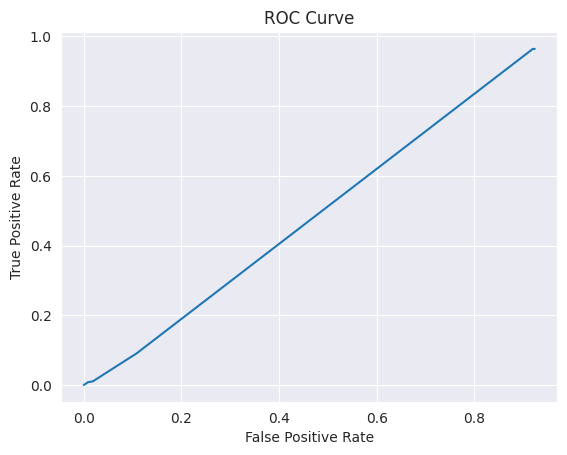

In [63]:
# Plotting the ROC curve
tprs,fprs = roc_curve(cnn)
models['cnn'] = [cnn,tprs,fprs]

1/1 [==============================] - 0s 31ms/step


Predictions for best threshold value: 0.4


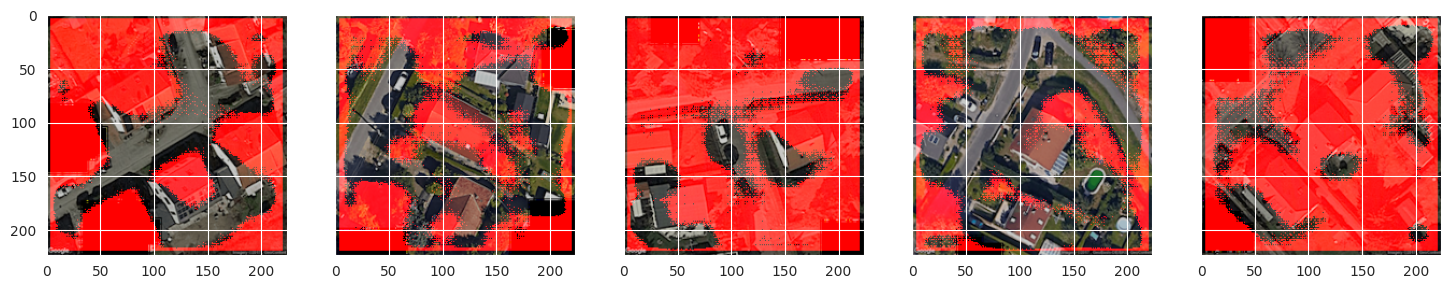

In [33]:
# Predictions on the test set by getting the best threshold from the ROC tprs, fprs values
test_predictions(cnn,tprs,fprs)

In [ ]:
# Observing the results of 5-fold Cross_Validation with Normal Images
# cv_cnn = CNN()
# cv(cv_cnn, 5,'normal')

#### Loading and training the CNN model with augmented images

In [34]:
# Define the model
aug_cnn = CNN()

# Getting images
imgs = img('augmented')

# Train the model
h_aug_cnn = aug_cnn.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))

# Storing the history
model_histories['aug_cnn'] = h_aug_cnn
# Plotting the accuracy and loss for train and validation data
# acc_loss_plot(h_aug_cnn)

Epoch 1/15
28/28 [==============================] - 6s 78ms/step - loss: 0.6631 - accuracy: 0.2093 - precision: 0.1514 - recall: 0.9627 - val_loss: 0.6448 - val_accuracy: 0.2102 - val_precision: 0.1580 - val_recall: 0.9549
Epoch 2/15
28/28 [==============================] - 2s 62ms/step - loss: 0.5354 - accuracy: 0.2273 - precision: 0.1479 - recall: 0.9062 - val_loss: 0.6674 - val_accuracy: 0.2102 - val_precision: 0.1580 - val_recall: 0.9549
Epoch 3/15
28/28 [==============================] - 2s 63ms/step - loss: 0.5148 - accuracy: 0.2197 - precision: 0.1505 - recall: 0.9402 - val_loss: 0.6465 - val_accuracy: 0.2102 - val_precision: 0.1580 - val_recall: 0.9549
Epoch 4/15
28/28 [==============================] - 2s 64ms/step - loss: 0.4968 - accuracy: 0.2202 - precision: 0.1513 - recall: 0.9469 - val_loss: 0.6180 - val_accuracy: 0.2102 - val_precision: 0.1580 - val_recall: 0.9549
Epoch 5/15
28/28 [==============================] - 2s 63ms/step - loss: 0.4649 - accuracy: 0.2369 - precisi

1/1 [==============================] - 0s 217ms/step


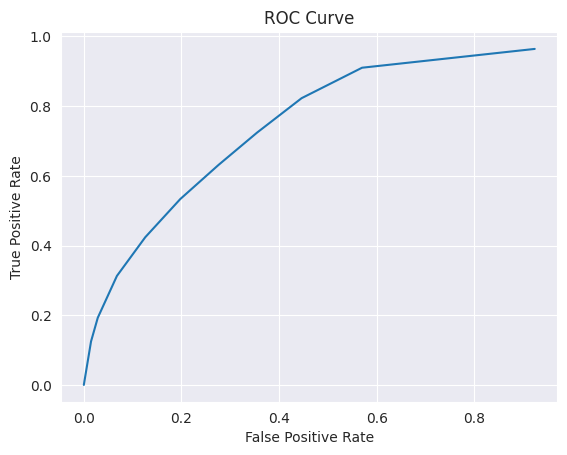

In [37]:
# Plotting the ROC curve
tprs,fprs = roc_curve(aug_cnn)

# Storing the model, tprs, fprs
models['aug_cnn'] = [aug_cnn,tprs,fprs]

1/1 [==============================] - 0s 24ms/step


Predictions for best threshold value: 0.15000000000000002


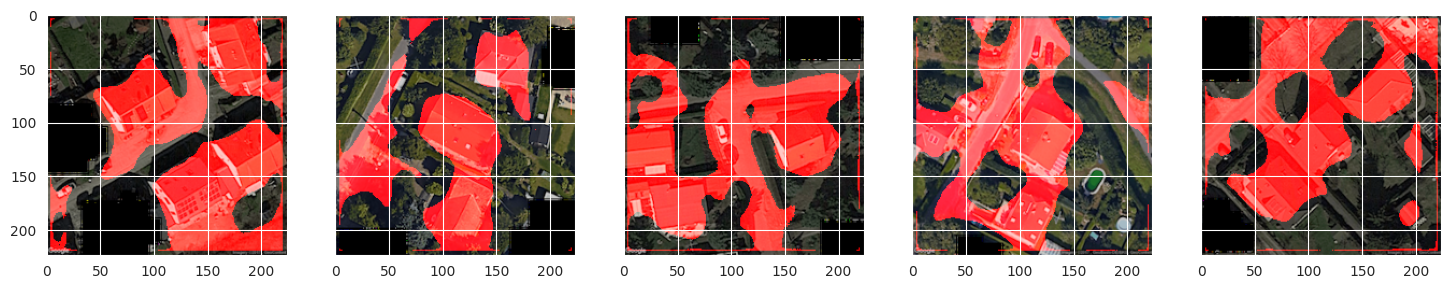

In [38]:
# Predictions on the test set
test_predictions(aug_cnn,tprs,fprs)

In [ ]:
# Observing the results of 5-fold Cross_Validation with Augmented Images
# cv_cnn = CNN()
# cv(aug_cnn, 5,'augmented')

### Base UNET: Trained From Scratch

In [58]:
def EncoderMiniBlock(inputs, n_filters:int=32, dropout_prob:float=0.3, max_pooling:bool=True):
  '''
  Return the encoding blocks to UNET architecture
  @param: inputs:  A prev layer architecture
  @param: n_filters: Number of filters to be used in conv layers
  @param: dropout_prob: Dropout Probabilities
  @param: max_pooling: Max pooling addition to encoder block
  '''
  conv = Conv2D(n_filters, (3,3), activation='relu', padding='same', kernel_initializer='HeNormal')(inputs)
  conv = Conv2D(n_filters, (3,3), activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
  conv = BatchNormalization()(conv, training=False)
  
  if dropout_prob > 0:     
      conv = tf.keras.layers.Dropout(dropout_prob)(conv)
  if max_pooling:
      next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
  else:
      next_layer = conv
  
  skip_connection = conv    
  return next_layer, skip_connection

def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters:int=32):
  '''
  Return the encoding blocks to UNET architecture
  @param: prev_layer_input:  A prev layer architecture
  @param: skip_layer_input: Conv Layers to be linked to Transpose layer
  @param: n_filtes: Number of filters to be used in transpose and conv layers
  '''
  up = Conv2DTranspose(n_filters, (3,3), strides=(2,2), padding='same')(prev_layer_input)
  merge = concatenate([up, skip_layer_input],axis = 3)
  conv = Conv2D(n_filters, (3,3), activation='relu', padding='same', kernel_initializer='HeNormal')(merge)
  conv = Conv2D(n_filters, (3,3), activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
  return conv

In [59]:
# Defining the UNET using the encoder and decoder functions
def Unet(input_size=(224, 224, 3), n_filters=16, n_classes=1,dropout_prob = 0):
  '''
  Returns a Unet Architecture Model
  @param: input_size: input size of image
  @param: n_filters: Number of filters to be used in architecture layers
  @param: n_classes: Total Classes to be predicted
  @param: dropout_prob: Dropout probabilities
  '''
  # Input size represent the size of 1 image (the size used for pre-processing)
  inputs = Input(input_size)

  # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
  # keeping dropout to be 0 because we have small dataset itself
  # We increase n_filters per layer to extract more features
  cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
  cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
  cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
  cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=dropout_prob, max_pooling=True)
  cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=dropout_prob, max_pooling=False) 

  # Decoder includes multiple mini blocks with decreasing number of filters
  # Skip connections from the encoder are given as input to the decoder
  # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
  ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
  ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
  ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
  ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

  # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
  # Followed by a 1x1 Conv layer to get the image to the desired size. 
  # Observe the number of channels will be equal to number of output classes
  conv9 = Conv2D(n_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)

  conv10 = Conv2D(n_classes, (1,1), padding='same', activation = 'sigmoid')(conv9)
  # This layer produces the final image output, representing the predicted probabilities for each pixel.
  # The sigmoid activation function is used to ensure the output values are between 0 and 1, representing the class probabilities.

  # Define the model
  model = Model(inputs=inputs, outputs=conv10,name = 'UNET')
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

#### Loading and training the UNET model without augmented images

In [ ]:
# Define the model
unet = Unet()

# Getting images
imgs = img('normal')

# Train the model
h_unet = unet.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))

# Storing the history
model_histories['unet'] = h_unet

# Plotting the accuracy and loss for train and validation data
# acc_loss_plot(h_unet)

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(unet)
models['unet'] = [unet,tprs,fprs]

In [ ]:
# Predictions on the test set
test_predictions(unet,tprs,fprs)

In [ ]:
# Observing the results of 5-fold Cross_Validation with Normal Images
# cv_unet = UNet()
# cv(cv_unet, 5,'normal')

#### Loading and training the CNN model with augmented images

In [ ]:
# Define the model
aug_unet = Unet()

# Getting images
imgs = img('augmented')

# Train the model
h_aug_unet = aug_unet.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))

# Storing the history
model_histories['aug_unet'] = h_aug_unet

# Plotting the accuracy and loss for train and validation data
# acc_loss_plot(h_aug_unet)

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(aug_unet)
models['aug_unet'] = [aug_unet,tprs,fprs]

In [ ]:
# Predictions on the test set
test_predictions(aug_unet,tprs,fprs)

In [ ]:
# Observing the results of 5-fold Cross_Validation with Augmented Images
# cv_unet = UNet()
# cv(cv_unet, 5,'augmented')

### Fine Tuned VGG16 and combined with Unet

In [ ]:
conv1 = ['block1_conv1','block1_conv2']
conv2 = ['block2_conv1','block2_conv2']
conv3 = ['block3_conv1','block3_conv2','block3_conv3']
conv4 = ['block4_conv1','block4_conv2','block4_conv3']
conv5 = ['block5_conv1','block5_conv2','block5_conv3']
pool1 = ['block1_pool']
pool2 = ['block2_pool']
pool3 = ['block3_pool']
pool4 = ['block4_pool']
pool5 = ['block5_pool']

## Observing the layers of the model
# VGG16 = vgg16.VGG16(include_top = False, weights = 'imagenet',input_shape = (224,224,3))
# train_layers =  conv5 
# non_train_layers = ['input_21']+pool1 + pool2 + pool3 + pool4 + pool5+conv1 + conv2  + conv3 + conv4
# for layer in VGG16.layers:
#   if layer.name in train_layers:
#     layer.trainable = True
#   if layer.name in non_train_layers:
#     layer.trainable = False
# layers = [(layer, layer.name, layer.trainable,layer.output.shape) for layer in VGG16.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])

In [ ]:
# def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
#   up = Conv2DTranspose(n_filters, (3, 3), 
#                        strides=(2, 2),
#                        padding='same',
#                        activation=LeakyReLU(0.1), 
#                        kernel_initializer='he_normal')(prev_layer_input)
#   up = BatchNormalization()(up)
#   merge = concatenate([up, skip_layer_input],axis = 3)
#   conv = Conv2D(n_filters, 
#                 3,  
#                 activation='relu',
#                 padding='same',
#                 kernel_initializer='HeNormal')(merge)
#   conv = Conv2D(n_filters,
#                 3, 
#                 activation='relu',
#                 padding='same',
#                 kernel_initializer='HeNormal')(conv)
#   return conv
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters:int=32):
  '''
  Return the encoding blocks to UNET architecture
  @param: prev_layer_input:  A prev layer architecture
  @param: skip_layer_input: Conv Layers to be linked to Transpose layer
  @param: n_filtes: Number of filters to be used in transpose and conv layers
  '''
  up = Conv2DTranspose(n_filters, (3,3), strides=(2,2), padding='same')(prev_layer_input)
  up = BatchNormalization()(up)
  merge = concatenate([up, skip_layer_input],axis = 3)
  conv = Conv2D(n_filters, (3,3), activation='relu', padding='same', kernel_initializer='HeNormal')(merge)
  conv = Conv2D(n_filters, (3,3), activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
  return conv

In [ ]:
def Vgg_Unet(input_size=(224, 224, 3), n_filters=16, n_classes=1,dropout_prob = 0):
  '''
  Returns a VGG Unet Architecture Model
  @param: input_size: input size of image
  @param: n_filters: Number of filters to be used in architecture layers
  @param: n_classes: Total Classes to be predicted
  @param: dropout_prob: Dropout probabilities
  '''

  # Loading a pretrained VGG 16 model
  VGG16 = vgg16.VGG16(include_top = False, weights = 'imagenet',input_shape = input_size)
  last_layer = VGG16.output

  # Defining which layers to train and which not to, since we have less images it's a good strategy to freeze the initial layers and only fine tune the last layer.
  train_layers =  conv5 
  non_train_layers = ['input_21'] + pool1 + pool2 + pool3 + pool4 + pool5+conv1 + conv2  + conv3 + conv4

  for layer in VGG16.layers:
    if layer.name in train_layers:
      layer.trainable = True
    if layer.name in non_train_layers:
      layer.trainable = False
  
  # Extending the VGG16 via unet's decoder block, similar to UNET Decoder Architecture Explanation.
  last_layer = VGG16.output
  unet = DecoderMiniBlock(last_layer,VGG16.get_layer("block5_conv3").output, n_filters*32)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block4_conv3").output, n_filters*32)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block3_conv3").output, n_filters*16)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block2_conv2").output, n_filters*8)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block1_conv2").output, n_filters*4)

  # Adding few final conv layers to get image output with the same size as that of the labels
  conv9 = Conv2D(n_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(unet)
  conv10 = Conv2D(n_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

  conv11 = Conv2D(n_classes, (1,1), activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv10)
  # This layer produces the final image output, representing the predicted probabilities for each pixel.
  # The sigmoid activation function is used to ensure the output values are between 0 and 1, representing the class probabilities.

  model = Model(VGG16.input, conv11)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

#### Loading and training the VGG combined with UNET model without augmented images

In [ ]:
# Define the model
vgg_unet = Vgg_Unet()

# Getting images
imgs = img('normal')

# Train the model
h_vgg_unet = vgg_unet.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))

# Storing the history
model_histories['vgg_unet'] = h_vgg_unet
# Plotting the accuracy and loss for train and validation data
# acc_loss_plot(h_vgg_unet)

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(vgg_unet, to_file='UNET with VGG16.png', show_shapes=True, rankdir='TB')
# layers = [(layer, layer.name, layer.trainable,layer.output.shape) for layer in vgg_unet.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(vgg_unet)
models['vgg_unet'] = [vgg_unet,tprs,fprs]

In [ ]:
# Predictions on the test set
test_predictions(vgg_unet,tprs,fprs)

In [ ]:
# Observing the results of 5-fold Cross_Validation with Normal Images
# cv_vgg_unet = Vgg_Unet()
# cv(vgg_unet, 5,'normal')

#### Loading and training the VGG combined with UNET model with augmented images

In [ ]:
# Define the model
aug_vgg_unet = Vgg_Unet()

# Getting images
imgs = img('augmented')

# Train the model
h_aug_vgg_unet = aug_vgg_unet.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))

# Storing the history
model_histories['aug_vgg_unet'] = h_aug_vgg_unet

# Plotting the accuracy and loss for train and validation data
# acc_loss_plot(h_aug_vgg_unet)

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(aug_vgg_unet)
models['aug_vgg_unet'] = [aug_vgg_unet,tprs,fprs]

In [ ]:
# Predictions on the test set
test_predictions(aug_vgg_unet,tprs,fprs)

In [ ]:
# Observing the results of 5-fold Cross_Validation with Augmented Images
# cv_vgg_unet = Vgg_Unet()
# cv(cv_vgg_unet, 5,'augmented')

### Fine Tuned MobileNet and combined with Unet

In [ ]:
def mobunet_model(input_size=(224, 224, 3), n_filters=16, n_classes=1,dropout_prob = 0):
  '''
  Returns a MobUnet Architecture Model
  @param: input_size: input size of image
  @param: n_filters: Number of filters to be used in architecture layers
  @param: n_classes: Total Classes to be predicted
  @param: dropout_prob: Dropout probabilities
  '''  
  # Using a pretrained mobileNet V2 architecture
  base_model = MobileNetV2(input_shape=[224, 224, 3], include_top=False)

  # Specify the layers whose activations will be used as skip connections
  layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
  
  # Retrieve the output tensors of the specified layers
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
  down_stack.trainable = False

  # Define the upsampling layers
  up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

  # Define the input layer
  inputs = Input(shape=input_size)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # Append another Conv2DTranspose layer with appropriate parameters
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, padding='same')(x)

  x = tf.keras.layers.Conv2D( filters=n_classes, kernel_size=(1,1), strides=1, padding='valid')(x)
    
  
  # Apply sigmoid activation function to obtain pixel-wise probabilities
  x = tf.keras.activations.sigmoid(x)

  x = Model(inputs = inputs, outputs = x)
  x.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return x

#### Loading and training the MobileNet combined with UNET model without augmented images

In [ ]:
# Define the model
mob_unet = mobunet_model()

# Getting images
imgs = img('normal')

# Train the model
h_mob_unet = mob_unet.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))

# Storing the History
model_histories['mob_unet'] = h_mob_unet

# Plotting the accuracy and loss for train and validation data
# acc_loss_plot(h_mob_unet)

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(mob_unet, to_file='UNET_Mob.png', show_shapes=True, rankdir='TB')
# layers = [(layer, layer.name, layer.trainable,layer.output) for layer in mob_unet.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(mob_unet)
models['mob_unet'] = [mob_unet,tprs,fprs]

In [ ]:
# Predictions on the test set
test_predictions(mob_unet,tprs,fprs)

In [ ]:
# Observing the results of 5-fold Cross_Validation with Normal Images
# cv_mob_unet = mobunet_model()
# cv(cv_mob_unet, 5,'normal')

#### Loading and training the MobileNet combined with UNET model with augmented images

In [ ]:
# Define the model
aug_mob_unet = mobunet_model()

# Getting images
imgs = img('augmented')

# Train the model
h_aug_mob_unet = aug_mob_unet.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))

# Storing the History
model_histories['aug_mob_unet'] = h_aug_mob_unet

# Plotting the accuracy and loss for train and validation data
# acc_loss_plot(h_aug_mob_unet)

In [ ]:
# Plotting the ROC curve and storing model with it's metrics
tprs,fprs = roc_curve(aug_mob_unet)
models['aug_mob_unet'] = [aug_mob_unet,tprs,fprs]

In [ ]:
# Predictions on the test set
test_predictions(aug_mob_unet,tprs,fprs)

In [ ]:
# Observing the results of 5-fold Cross_Validation with Augmented Images
# cv_mob_unet = mobunet_model()
# cv(cv_mob_unet, 5,'augmented')

In [ ]:
# %cd /content/gdrive/MyDrive/images/dida_task_dummy

## Final Observations & Take Aways

In [ ]:
join_plots(model_histories)